C:\Users\thoma\Desktop\Data Stream\M2DS_DataStream-main\First training.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
import tensorflow.keras.layers as layers
tf.random.set_seed(42)
np.random.seed(42)

### helper functions and data pre-processing

In [2]:
def preprocess_sentiment_tweeter(data):
    list_sentiment = []
    for val in data_tweeter_sentiment_to_preprocess:
        if val[-1] in ['0','1','-1']:
            list_sentiment += [val[-1]]
    return np.array(list_sentiment)[:5112]

def scaler(x,x_ref):
  return (x-np.mean(x_ref))/np.max(np.abs(x_ref-np.mean(x_ref)))

def unscaler(x,x_ref):
  return x*np.max(np.abs(x_ref-np.mean(x_ref)))+np.mean(x_ref)

Text(0.5, 1.0, '$GOOG price groundtruth')

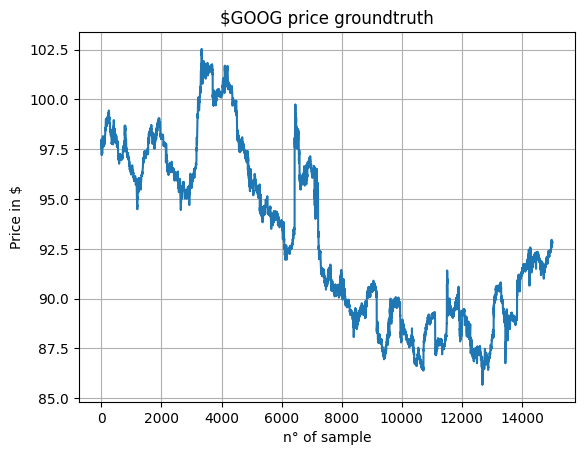

In [3]:
data_close = np.load('data\GOOG_1m_2022-11-17_2023-01-13_array.npy',allow_pickle=True)
plt.plot(data_close)
plt.xlabel('n° of sample')
plt.ylabel('Price in $')
plt.grid()
plt.title('$GOOG price groundtruth')

In [4]:
lenght_min_used_for_prediction = 60
number_point_predicted = 1


y = []
x = []
index = []
for value_index in range(data_close.shape[0]-number_point_predicted):
    if value_index - int(lenght_min_used_for_prediction/2) < 0:
        pass
    else:
        x.append(data_close[value_index - int(lenght_min_used_for_prediction/2):value_index])
        y.append(data_close[value_index:number_point_predicted+value_index])
        index.append(value_index)
        #y.append(np.sign(data_close[value_index:value_index+number_point_predicted]-data_close[value_index-1:value_index+number_point_predicted-1]))#1>=1+np.sign(data_close[value_index:value_index+number_point_predicted]-data_close[value_index-1:value_index+number_point_predicted-1]))


y = np.array(y).astype('float32')
x = np.array(x).astype('float32')

x = np.reshape(x, (x.shape[0], x.shape[1],1))

In [5]:
partitioner_test_train = 0.2
x_train ,x_test = x[:int(x.shape[0]*partitioner_test_train),:,:],x[int(x.shape[0]*partitioner_test_train):,:,:]
x_train,x_test = scaler(x_train,x_train),scaler(x_test,x_train)

y_train_unscaled, y_test_unscaled = y[:int(x.shape[0]*partitioner_test_train),:],y[int(x.shape[0]*partitioner_test_train):,:]
y_train,y_test = scaler(y_train_unscaled,y_train_unscaled),scaler(y_test_unscaled,y_train_unscaled)

x_train,x_test = tf.convert_to_tensor(x_train),tf.convert_to_tensor(x_test)

## Training of a learn once model

strucuture:
- LSTM (100 hidden units)
- LSTM (100 hidden units)
- Dense (25 hidden units) 
- output (one outputing unit)

In [6]:
model_still = Sequential([
                    LSTM(100,return_sequences=True,input_shape=[int(lenght_min_used_for_prediction/2),1]),
                    LSTM(100,input_shape=[int(lenght_min_used_for_prediction/2),1]),
                    Dense(25),
                    Dense(number_point_predicted) 
                  ])


model_still.build(input_shape = [30,1])
print(model_still.summary())
model_still.predict(x[0:1,:,:])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 2s 2s/step


array([[0.37822807]], dtype=float32)

In [7]:
model_still.compile(loss='MSE', optimizer='adam')
model_still.fit(x_train, y_train, batch_size=60,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
50/50 [==============================] - 4s 35ms/step - loss: 0.0164 - val_loss: 0.8023
Epoch 2/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0033 - val_loss: 0.5453
Epoch 3/10
50/50 [==============================] - 1s 24ms/step - loss: 0.0027 - val_loss: 0.3267
Epoch 4/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0024 - val_loss: 0.3214
Epoch 5/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0021 - val_loss: 0.2283
Epoch 6/10
50/50 [==============================] - 1s 26ms/step - loss: 0.0020 - val_loss: 0.3148
Epoch 7/10
50/50 [==============================] - 1s 26ms/step - loss: 0.0018 - val_loss: 0.2839
Epoch 8/10
50/50 [==============================] - 1s 26ms/step - loss: 0.0017 - val_loss: 0.2265
Epoch 9/10
50/50 [==============================] - 1s 26ms/step - loss: 0.0015 - val_loss: 0.1074
Epoch 10/10
50/50 [==============================] - 1s 26ms/step - loss: 0.0013 - val_loss: 0.1031


In [8]:
y_predicted_still = model_still.predict(x_test)

375/375 [==============================] - 2s 4ms/step


Text(0.5, 1.0, '$GOOG price prediction and groundtruth')

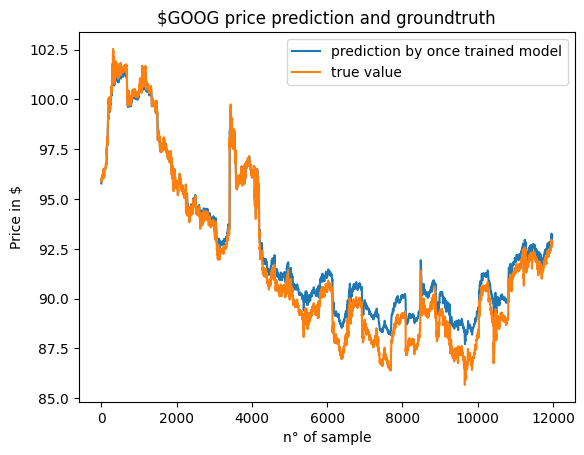

In [9]:
plt.plot(unscaler(y_predicted_still[:,0],y_train_unscaled),label='prediction by once trained model')
plt.plot(unscaler(y_test[:,0],y_train_unscaled),label='true value')
plt.legend()
plt.xlabel('n° of sample')
plt.ylabel('Price in $')
plt.title('$GOOG price prediction and groundtruth')

## Training of a stream learning model

This model has the same structure as previously

In [10]:
model_rolling = Sequential([
                    LSTM(100,return_sequences=True,input_shape=[int(lenght_min_used_for_prediction/2),1]),
                    LSTM(100,input_shape=[int(lenght_min_used_for_prediction/2),1]),
                    Dense(number_point_predicted)
                  ])

model_rolling.build(input_shape = [30,1])
print(model_rolling.summary())
model_rolling.predict(x[0:1,:,:])
model_rolling.compile(loss='MSE', optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 430ms/step


In [11]:

continual_batch_number = 50
y_len = y_test.shape[0]
y_predicted_rolling = [] # stocke les predicted avant chaque training
for batch_number in range(continual_batch_number):
  if batch_number%10==0 : print(batch_number);
  first_index= batch_number*int(y_len/continual_batch_number)
  second_index = (batch_number+1)*int(y_len/continual_batch_number)

  y_to_evaluate = scaler(y[first_index:second_index,:] ,y_train_unscaled)
  x_to_evaluate = x[first_index:second_index,:,:]

  train_first_index = max(0,second_index-800)
  y_to_train = scaler(y[train_first_index:second_index,:] ,y_train_unscaled)
  x_to_train = x[train_first_index:second_index,:,:]

  y_predicted_rolling += model_rolling.predict(x_to_evaluate).tolist()

  model_rolling.fit(x_to_train, y_to_train, batch_size=10,epochs=5,verbose=0)

0
8/8 [==============================] - 0s 3ms/step
10
8/8 [==============================] - 0s 3ms/step
20
8/8 [==============================] - 0s 3ms/step
30
8/8 [==============================] - 0s 4ms/step
40
8/8 [==============================] - 0s 3ms/step


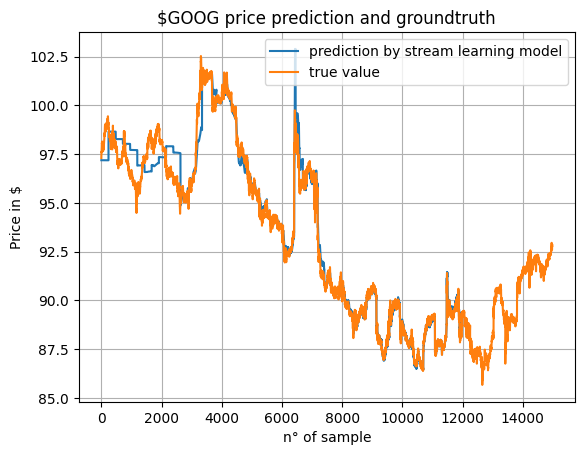

In [12]:
plt.plot(unscaler(np.array(y_predicted_rolling),y_train_unscaled),label='prediction by stream learning model')
plt.plot(y,label='true value')
plt.xlabel('n° of sample')
plt.ylabel('Price in $')
plt.title('$GOOG price prediction and groundtruth')
plt.grid()
plt.legend()

## Comparison of the stream learning model and the learn once one

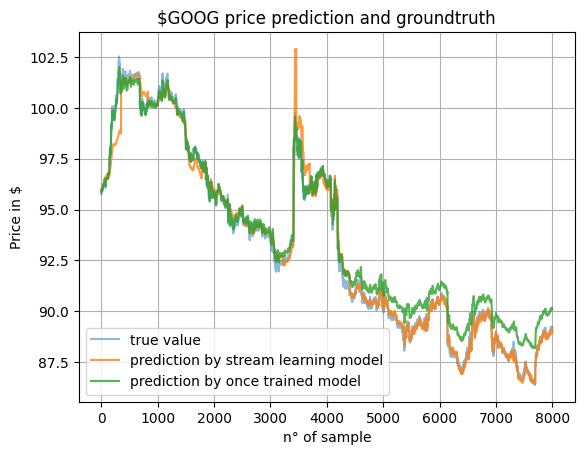

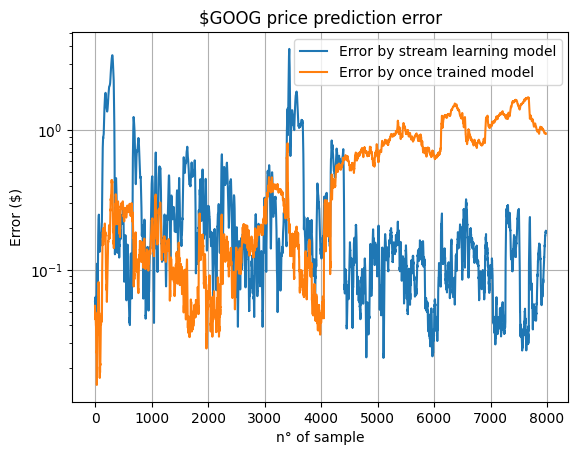

In [13]:
rolling_unscaled = unscaler(np.array(y_predicted_rolling[int(y.shape[0]*partitioner_test_train):]),y_train_unscaled)
still_unscaled = unscaler(y_predicted_still,y_train_unscaled)

plt.plot(y_test_unscaled[:8000],label = 'true value',alpha = 0.5)
plt.plot(rolling_unscaled[:8000] ,label = 'prediction by stream learning model',alpha = 0.8)

plt.plot(still_unscaled[:8000],label = 'prediction by once trained model',alpha = 0.8)

plt.xlabel('n° of sample')
plt.ylabel('Price in $')
plt.title('$GOOG price prediction and groundtruth')

plt.legend()
plt.grid()
plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

diff_rolling = np.abs(rolling_unscaled[:8000]-y_test_unscaled[:8000])
diff_still = np.abs(still_unscaled[:8000]-y_test_unscaled[:8000])
plt.plot(moving_average(diff_rolling[:,0],20),label='Error by stream learning model')
plt.plot(moving_average(diff_still[:,0],20),label='Error by once trained model')
plt.legend()
plt.yscale('log')
plt.xlabel('n° of sample')
plt.title('$GOOG price prediction error')
plt.ylabel('Error ($)')
plt.grid()
plt.show()


## Adding tweeter sentiment to the stream learning model

In [42]:
data_raw = pd.read_csv("data\GOOG_2m_2023-01-04_2023-01-10.csv")
data_tweeter_close = data_raw['Close'].values
tweet_raw = pd.read_csv("data\GOOG_2m_2023-01-04_2023-01-10_0_tweets.csv",sep=';')
data_tweeter_sentiment_to_preprocess = tweet_raw['googl_iter,tweet_number,tweet date,query,TweetText,sentiment'].values
data_tweeter_sentiment =preprocess_sentiment_tweeter(data_tweeter_sentiment_to_preprocess).astype('int')

In [47]:
lenght_min_used_for_prediction = 60
number_point_predicted = 1


y = []
x, x_tweeter = [], []
index = []
sentiment_roller = 0
for value_index in range(data_tweeter_close.shape[0]-number_point_predicted):
    if value_index - int(lenght_min_used_for_prediction/2) < 0:
        pass
    else:
        sentiment = np.mean(data_tweeter_sentiment[sentiment_roller : sentiment_roller + 6])
        sentiment_roller += 6
        x_tweeter.append([sentiment] + data_tweeter_close[value_index - int(lenght_min_used_for_prediction/2):value_index].tolist() )
        x.append(data_tweeter_close[value_index - int(lenght_min_used_for_prediction/2):value_index])
        y.append(data_tweeter_close[value_index:number_point_predicted+value_index])
        index.append(value_index)
        

y = np.array(y).astype('float32')
y_train_unscaled = y[:int(y.shape[0]*0.2)]
y = scaler(y,y_train_unscaled)

x = np.array(x).astype('float32')
x_tweeter = np.array(x_tweeter).astype('float32')

x = np.reshape(x, (x.shape[0], x.shape[1],1))
x_tweeter = np.reshape(x_tweeter, (x_tweeter.shape[0], x_tweeter.shape[1],1))

x = tf.convert_to_tensor(x)
x_tweeter = tf.convert_to_tensor(x_tweeter)


In [48]:
model_rolling = Sequential([
                    LSTM(100,return_sequences=True,input_shape=[int(lenght_min_used_for_prediction/2),1]),
                    LSTM(100,input_shape=[int(lenght_min_used_for_prediction/2),1]),
                    Dense(number_point_predicted)
                  ])

model_rolling.build(input_shape = [30,1])
print(model_rolling.summary())
model_rolling.predict(x[0:1,:,:])
model_rolling.compile(loss='MSE', optimizer='adam')

model_rolling_tweeter = Sequential([
                    LSTM(100,return_sequences=True,input_shape=[int(lenght_min_used_for_prediction/2)+1,1]),
                    LSTM(100,input_shape=[int(lenght_min_used_for_prediction/2)+1,1]),
                    Dense(number_point_predicted)
                  ])

model_rolling_tweeter.build(input_shape = [31,1])
print(model_rolling_tweeter.summary())
model_rolling_tweeter.predict(x_tweeter[0:1,:,:])
model_rolling_tweeter.compile(loss='MSE', optimizer='adam')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 30, 100)           40800     
                                                                 
 lstm_29 (LSTM)              (None, 100)               80400     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 418ms/step
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 31, 100)           40800     
                                

In [49]:

continual_batch_number = 15
y_len = y.shape[0]
y_predicted_rolling = [] # stocke les predicted avant chaque training
y_predicted_tweeter = []

for batch_number in range(continual_batch_number):
  print(batch_number,' iteration sur ',continual_batch_number,' en cours)
  first_index= batch_number*int(y_len/continual_batch_number)
  second_index = (batch_number+1)*int(y_len/continual_batch_number)

  y_to_evaluate = y[first_index:second_index,:]
  x_to_evaluate = x[first_index:second_index,:,:]
  x_to_evaluate_tweeter = x_tweeter[first_index:second_index,:,:]

  y_to_train = y[:second_index,:] 
  x_to_train = x[:second_index,:,:]
  x_to_train_tweeter =  x_tweeter[:second_index,:,:]

  y_predicted_rolling += model_rolling.predict(x_to_evaluate,verbose = 0).tolist()
  y_predicted_tweeter += model_rolling_tweeter.predict(x_to_evaluate_tweeter,verbose = 0).tolist()

  model_rolling.fit(x_to_train, y_to_train, batch_size=5,epochs=20,verbose=0)
  model_rolling_tweeter.fit(x_to_train_tweeter, y_to_train, batch_size=5,epochs=20,verbose=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


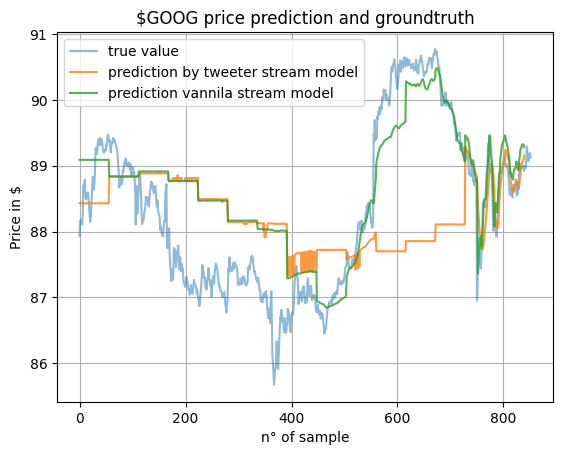

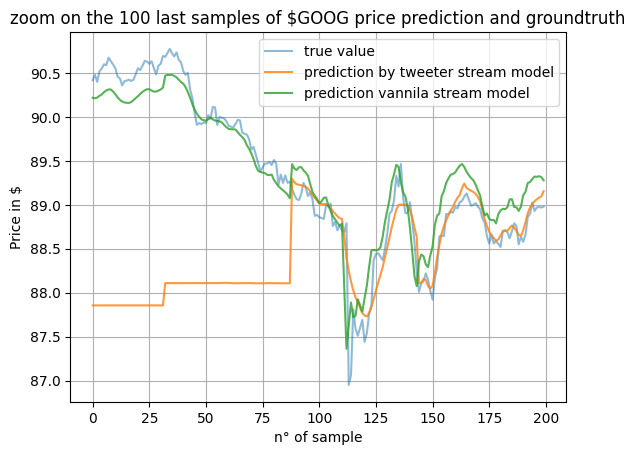

In [57]:
rolling_unscaled = unscaler(np.array(y_predicted_rolling),y_train_unscaled)
rolling_unscaled_tweeter = unscaler(np.array(y_predicted_tweeter),y_train_unscaled)
y_unscaled = unscaler(y,y_train_unscaled)
plt.plot(y_unscaled, label = 'true value',alpha = 0.5)
plt.plot(rolling_unscaled_tweeter, label = 'prediction by tweeter stream model',alpha = 0.8)

plt.plot(rolling_unscaled,label = 'prediction vannila stream model',alpha = 0.8)

plt.xlabel('n° of sample')
plt.ylabel('Price in $')
plt.title('$GOOG price prediction and groundtruth')

plt.legend()
plt.grid()
plt.show()


plt.plot(y_unscaled[-215:-15], label = 'true value',alpha = 0.5)
plt.plot(rolling_unscaled_tweeter[-200:], label = 'prediction by tweeter stream model',alpha = 0.8)

plt.plot(rolling_unscaled[-200:],label = 'prediction vannila stream model',alpha = 0.8)

plt.xlabel('n° of sample')
plt.ylabel('Price in $')
plt.title('zoom on the 100 last samples of $GOOG price prediction and groundtruth')

plt.legend()
plt.grid()
plt.show()

